# Artificial neural network

In [1]:
#imports
from preprocessing.preprocessing import get_preprocessed_brfss_dataset
from preprocessing.neural_network_preprocessing import get_number_of_numerical_features, NeuralNetworkPreprocessor, CATEGORICAL_COLUMNS, NUMERICAL_COLUMNS
from visualization.general_plots import plot_class_frequencies
from visualization.neural_network_plots import plot_loss, plot_accuracy

from sklearn.metrics import fbeta_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
use_mps = True
use_cuda = False

device = torch.device("cpu")

if torch.has_mps and use_mps:
    device = torch.device("mps")
    print("Torch mps activated")

if torch.has_cuda and use_cuda:
    device = torch.device("cuda")
    print("Torch cuda activated")

Torch mps activated


Looking at the dataset it becomes clear that it is imbalanced

In [ ]:
preprocessor = NeuralNetworkPreprocessor()
data_train, data_test, target_train, target_test = preprocessor.get_preprocessed_dataset_for_neural_network()
target_train.head(10)

In [6]:
#constants
batch_size = 128
output_size = target_train.shape[1]
embedding_sizes = preprocessor.get_embedding_sizes()
embedding_input_size = sum((nf for ni, nf in embedding_sizes))
numerical_input_size = get_number_of_numerical_features()
input_size = embedding_input_size + numerical_input_size
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")
print(f"Embedding sizes: {embedding_sizes}")

Input size: 51
Output size: 4
Embedding sizes: [(6, 3), (2, 1), (3, 2), (6, 3), (4, 2), (3, 2), (2, 1), (3, 2), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (8, 4), (3, 2), (13, 7), (5, 3), (4, 2), (2, 1), (4, 2), (2, 1), (2, 1), (4, 2), (2, 1)]


In [8]:
class CustomBrfssDataset(data_utils.Dataset):
    def __init__(self, dataset_complete, dataset_target):
        self.data_categorical = dataset_complete[CATEGORICAL_COLUMNS]
        self.data_categorical = torch.tensor(np.array(self.data_categorical)).int()

        self.data_numerical = dataset_complete[NUMERICAL_COLUMNS]
        self.data_numerical = torch.tensor(np.array(self.data_numerical)).float()

        self.target = torch.tensor(np.array(dataset_target)).float()

    def __len__(self):
            return len(self.data_categorical)

    def __getitem__(self, idx):
            return self.data_categorical[idx], self.data_numerical[idx], self.target[idx]

Create torch data loader

In [9]:
train_dataset = CustomBrfssDataset(data_train, target_train)
test_dataset = CustomBrfssDataset(data_test, target_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Create artificial net, define loss function and define optimizer

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        self.batch_norm_numerical = nn.BatchNorm1d(numerical_input_size)
        self.dropout_embedding = nn.Dropout(0.3)

        self.fc1 = nn.Linear(input_size, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.do1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 5)
        self.bn2 = nn.BatchNorm1d(5)
        self.do2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(5, output_size)

    def forward(self, input_categorical, input_numerical):
        embedding_layers = []
        for index,e in enumerate(self.embeddings):
            embedding_layers.append(e(input_categorical[:,index]))
        x_categorical = torch.cat(embedding_layers, 1)
        x_categorical = self.dropout_embedding(x_categorical)

        x_numerical = self.batch_norm_numerical(input_numerical)
        x = torch.cat([x_categorical, x_numerical], 1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu_(x)
        x = self.do1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu_(x)
        x = self.do2(x)
        x = self.fc3(x)
        x = F.softmax(x)
        return x

In [11]:
def get_accuracy(model: Net, data_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct/total

def get_loss(model: Net, criterion, data_loader):
    running_loss = 0.0

    model.train()
    for i, data in enumerate(data_loader, 0):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        pass

    return running_loss/len(data_loader)

def get_f_score(model: Net, data_loader):
    running_predictions = []
    running_labels = []

    model.eval()
    for i, data in enumerate(data_loader, 0):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels.data, 1)
        running_predictions.extend(predicted.detach().cpu().numpy().ravel())
        running_labels.extend(labels.detach().cpu().numpy().ravel())

        pass

    return fbeta_score(running_labels, running_predictions, beta=2, average="micro")



Training loop

In [12]:
def train_network(model: Net, criterion, optimizer, data_train_loader, data_validation_loader, n_epochs=5):
    loss_values = []
    accuracy_values = []
    loss_values_validation = []
    accuracy_values_validation = []
    f_scores = []
    f_scores_validation = []

    for epoch in range(n_epochs):

        running_loss = 0.0

        model.train()
        for i, data in enumerate(data_train_loader, 0):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # print every 100 batches
                print(f'[{epoch + 1}, {(i + 1) * batch_size}] loss: {running_loss / i:.3f}')

            pass

        loss_values.append(running_loss/len(data_train_loader))
        validation_loss = get_loss(model, criterion, data_validation_loader)
        train_accuracy = 100 * get_accuracy(model, data_train_loader)
        validation_accuracy = 100 * get_accuracy(model, data_validation_loader)
        accuracy_values.append(train_accuracy)
        accuracy_values_validation.append(validation_accuracy)
        loss_values_validation.append(validation_loss)

        f_train = get_f1_score(net, data_train_loader)
        f_validation = get_f1_score(net, data_validation_loader)
        f_scores.append(f_train)
        f_scores_validation.append(f_validation)

        print(f"Epoch {epoch} loss: {str(running_loss/len(data_train_loader))}")
        print(f"Epoch {epoch} validation loss: {validation_loss}")
        print(f'Train accuracy epoch {epoch}: {train_accuracy} %')
        print(f'Validation accuracy epoch {epoch}: {validation_accuracy} %')
        print(f"Train F2-score : {f_train}")
        print(f"Validation F2-score : {f_validation}")

    print('Finished Training')
    return loss_values, loss_values_validation, accuracy_values, accuracy_values_validation, f_scores, f_scores_validation

### Train model without under or oversampling

In [13]:
net = Net()
net.to(device)

criterion_cross_entropy = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)

loss_values, accuracy_values = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_loader=train_loader)

[1, 25600] loss: 1.329
[1, 51200] loss: 1.251
[1, 76800] loss: 1.189
[1, 102400] loss: 1.141
[1, 128000] loss: 1.106
[1, 153600] loss: 1.078
[1, 179200] loss: 1.057
[1, 204800] loss: 1.040
[1, 230400] loss: 1.026
Epoch 0 loss: 1.0255471455093237
Accuracy epoch 0: 64.7579095017923 %
[2, 25600] loss: 0.913
[2, 51200] loss: 0.912
[2, 76800] loss: 0.910
[2, 102400] loss: 0.909
[2, 128000] loss: 0.908
[2, 153600] loss: 0.907
[2, 179200] loss: 0.906
[2, 204800] loss: 0.905
[2, 230400] loss: 0.904
Epoch 1 loss: 0.9037387195386385
Accuracy epoch 1: 85.017836424403 %
[3, 25600] loss: 0.903
[3, 51200] loss: 0.901
[3, 76800] loss: 0.900
[3, 102400] loss: 0.899
[3, 128000] loss: 0.898
[3, 153600] loss: 0.898
[3, 179200] loss: 0.898
[3, 204800] loss: 0.897
[3, 230400] loss: 0.897
Epoch 2 loss: 0.8964232397211556
Accuracy epoch 2: 85.017836424403 %
[4, 25600] loss: 0.898
[4, 51200] loss: 0.896
[4, 76800] loss: 0.895
[4, 102400] loss: 0.895
[4, 128000] loss: 0.895
[4, 153600] loss: 0.895
[4, 179200] 

In [15]:
print(f'Accuracy : {100 * get_accuracy(net, test_loader)} %')

Accuracy : 85.01740350148059 %


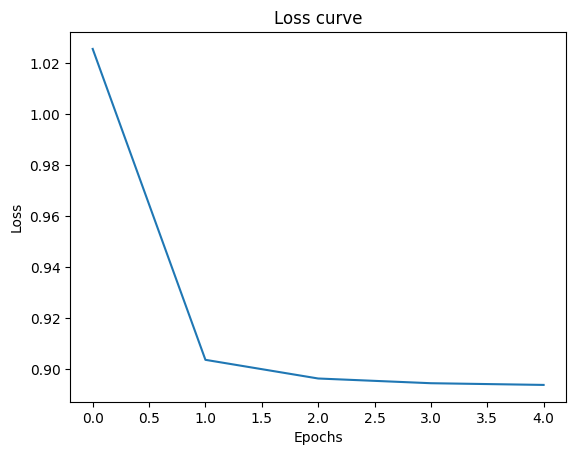

In [16]:
plot_loss(loss_values)

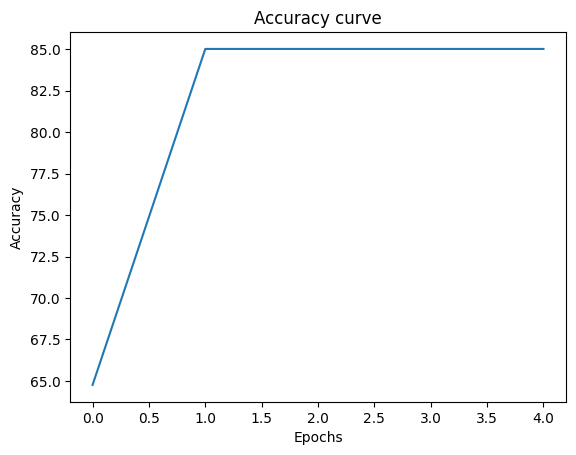

In [17]:
plot_accuracy(accuracy_values)

### Train model with undersampling

In [20]:
data_train, data_test, target_train, target_test = preprocessor.get_preprocessed_dataset_for_neural_network_undersampled()

train_dataset = CustomBrfssDataset(data_train, target_train)
test_dataset = CustomBrfssDataset(data_test, target_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

net = Net()
net.to(device)

criterion_cross_entropy = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)

loss_values, accuracy_values = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_loader=train_loader)

Epoch 0 loss: 1.386391814677946
Accuracy epoch 0: 25.44529262086514 %
Epoch 1 loss: 1.3863206390411622
Accuracy epoch 1: 25.0 %
Epoch 2 loss: 1.386315430364301
Accuracy epoch 2: 25.0 %
Epoch 3 loss: 1.3863292124963575
Accuracy epoch 3: 25.0 %
Epoch 4 loss: 1.3863066396405619
Accuracy epoch 4: 25.0 %
Finished Training
